In [1]:
""" IMPORTS """
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import seaborn
import scipy.stats as si
from scipy import optimize
from scipy import stats
from scipy.stats import norm
import scipy.optimize as sco
import sympy as sy
from sympy.stats import Normal, cdf
from datetime import timedelta, date, datetime
from mpl_toolkits import mplot3d
%matplotlib inline
from scipy.interpolate import interp2d

## Random Walks

Downloading Apple stock's prices (ticker : 'AAPL') from Yahoo Finance (from 01.01.2020 to today).

[*********************100%***********************]  1 of 1 completed


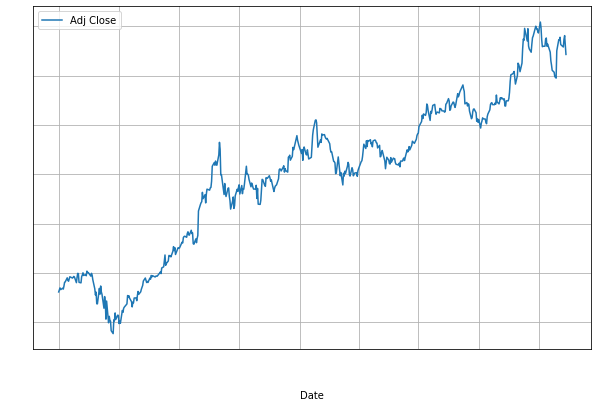

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-07,172.860001,173.949997,170.949997,171.660004,171.660004,77251200
2022-02-08,171.729996,175.350006,171.429993,174.830002,174.830002,74829200
2022-02-09,176.050003,176.649994,174.899994,176.279999,176.279999,71285000
2022-02-10,174.139999,175.479996,171.550003,172.119995,172.119995,90865900
2022-02-11,172.330002,173.080002,168.039993,168.639999,168.639999,98566000


In [2]:
df = yf.download('AAPL', start='2020-01-01')
df['Adj Close'].plot(figsize=(10,7))
plt.tick_params(axis='both', colors='white')
plt.legend()
plt.grid()
plt.show()
df.tail()

Text(0.5, 1.0, 'AAPL Moving Average')

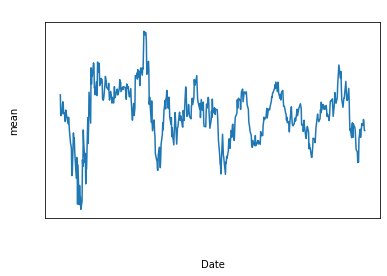

In [3]:
df['change'] = df['Adj Close'].pct_change()
df['rolling_mean'] = df['change'].rolling(20).mean() * 252

df.rolling_mean.plot()
plt.tick_params(axis='both', colors='white')
plt.ylabel('mean')
plt.title('AAPL Moving Average', color='white')

Text(0.5, 1.0, 'AAPL Rolling Volatility')

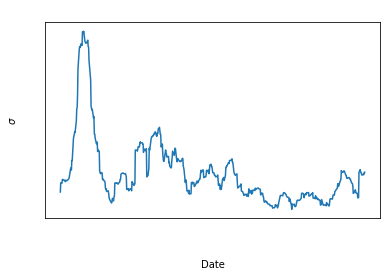

In [4]:
df['change'] = df['Adj Close'].pct_change()
df['rolling_sigma'] = df['change'].rolling(20).std() * np.sqrt(252)

df.rolling_sigma.plot()
plt.tick_params(axis='both', colors='white')
plt.ylabel('$\sigma$')
plt.title('AAPL Rolling Volatility', color='white')

Estimating stock price parameters (expected value, variance), for the sub-period from 01.01.2020 to 28.02.2020.

In [5]:
""" Preparing parameters """
starting_sub_period = '2020-01-01'
ending_sub_period = '2020-02-28'
sub_period = df['Adj Close'].loc[starting_sub_period:ending_sub_period]
t = np.busday_count(starting_sub_period, ending_sub_period)

In [6]:
lag = 1
returns_sub_period = sub_period.pct_change(lag)

expected_price_sub_period = sub_period.rolling(len(sub_period)).mean()
variance_price_sub_period = sub_period.rolling(len(sub_period)).var()
returns_mean_sub_period = returns_sub_period.mean()
returns_mean_sub_period_annualised = returns_mean_sub_period * 252/lag
returns_var_sub_period = returns_sub_period.var()
returns_var_sub_period_annualised = returns_var_sub_period * 252/lag

print('Adj Close sub period mean: ', '{:0.2f} USD'.format(expected_price_sub_period[-1]))
print('Adj Close sub period variance: ', '{:0.2f}'.format(variance_price_sub_period[-1]))
print('Daily returns sub period mean: ', '{:0.2f}%'.format(returns_mean_sub_period * 100))
print('Daily returns sub period annualized mean: ', '{:0.2f}%'.format(returns_mean_sub_period_annualised * 100))
print('Daily returns sub period variance: ', '{:0.2f}%'.format(returns_var_sub_period * 100))
print('Daily returns sub period annualized variance: ', '{:0.2f}%'.format(returns_var_sub_period_annualised * 100))

Adj Close sub period mean:  76.73 USD
Adj Close sub period variance:  10.51
Daily returns sub period mean:  -0.21%
Daily returns sub period annualized mean:  -53.64%
Daily returns sub period variance:  0.04%
Daily returns sub period annualized variance:  11.32%


In [7]:
""" Preparing parameters """
# compute volatility using Pandas rolling and std methods, the trading days is set to 252 days
TRADING_DAYS = 252
lag = 1
returns = df['Adj Close'].pct_change(lag)
returns_mean = returns.mean()
returns_mean_annualised = returns_mean * TRADING_DAYS/lag
returns_var = returns.var() * TRADING_DAYS/lag 
returns_std = returns.std() * ((TRADING_DAYS/lag)**0.5) 
expected_price_ = df['Adj Close'].rolling(len(sub_period)).mean()

print('Daily Adj close mean: ', '{:0.2f}'.format(expected_price_[-1]))
print('Daily return mean: ', '{:0.2f}%'.format(returns_mean * 100))
print('Daily return variance: ', '{:0.2f}%'.format(returns.var() * 100))
print('Annualized mean: ', '{:0.2f}%'.format(returns_mean_annualised * 100))
print('Annualized variance: ', '{:0.2f}%'.format(returns_var * 100))

Daily Adj close mean:  172.05
Daily return mean:  0.19%
Daily return variance:  0.05%
Annualized mean:  46.92%
Annualized variance:  13.80%


Generating 100 random walks for the prices from 01.03.2021 to today.

In [8]:
""" Preparing parameters """
begin_date = '2021-03-01'
end_date = datetime.today().strftime('%Y-%m-%d')
t = np.busday_count(begin_date, end_date)
paths = 100
df['daily_pct_change'] = df['Adj Close'].pct_change() 
initial_price = df['Adj Close'][begin_date]
mu = df['daily_pct_change'].iloc[:-t].mean()
sigma = df['daily_pct_change'].iloc[:-t].std()
simulation = {}
simulation['Actual'] = list(df['Adj Close'].loc[begin_date:].values)

for sim in range(paths):
    simulation["Simulation_"+str(sim)] = [df['Adj Close'].loc[begin_date]]
    for days in range(len(df['Adj Close'].loc[begin_date:])-1):
        next_day = simulation["Simulation_"+str(sim)][-1]*np.exp((mu-(sigma**2/2))+sigma*np.random.normal())
        simulation["Simulation_"+str(sim)].append(next_day)

simulation = pd.DataFrame(simulation)
simulation
# simulation_ a t ligne et 100 colonnes
# on veut len(df)-t

,Actual,Simulation_0,Simulation_1,Simulation_2,Simulation_3,Simulation_4,Simulation_5,Simulation_6,Simulation_7,Simulation_8,...,Simulation_90,Simulation_91,Simulation_92,Simulation_93,Simulation_94,Simulation_95,Simulation_96,Simulation_97,Simulation_98,Simulation_99
0,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,...,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973,127.034973
1,124.380745,131.404450,128.413263,127.663858,119.236546,123.263688,128.556696,128.133394,129.298419,126.887291,...,131.961099,126.475046,127.292832,123.474500,125.510205,130.268030,122.642278,130.278196,129.769112,129.657558
2,121.338814,133.693710,127.239024,135.543647,114.205019,128.765377,124.383824,134.935553,128.845677,128.540647,...,132.059906,125.356634,123.679373,123.190260,120.145716,124.090260,125.203644,124.368370,127.801847,129.890297
3,119.420219,133.248017,123.006592,138.603603,115.663279,127.657352,124.730234,131.048505,133.073254,125.562018,...,136.589641,128.599483,123.847413,127.043072,120.906136,126.957714,122.106964,122.726571,125.583329,124.233661
4,120.702591,132.833027,127.316207,136.194754,119.219693,124.000695,119.123082,131.631170,136.350065,129.504252,...,139.390810,128.916357,123.845062,130.182531,125.367540,130.948483,120.454753,122.205559,124.519963,124.716301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,171.660004,153.387264,125.788404,250.823231,134.834435,321.405889,241.290476,216.018577,300.713698,246.633280,...,189.013097,602.000443,364.033643,184.555353,248.366974,97.495076,135.798755,193.392281,87.621337,201.409561
239,174.830002,154.451262,124.697023,253.204860,132.091138,313.893855,236.712312,224.442408,279.796362,258.246143,...,183.339760,598.797880,350.034194,183.639301,252.493206,94.089862,137.755528,196.109046,90.205479,205.464333
240,176.279999,151.283540,120.895880,245.826294,127.881614,319.007226,238.422985,220.837544,279.415383,272.910647,...,182.930178,553.774390,371.500977,182.325818,247.579068,94.572967,142.106192,192.015572,92.647685,204.682519
241,172.119995,153.951876,124.417890,252.510120,132.485107,319.446984,242.193568,222.278245,281.931105,263.901071,...,169.746788,539.446423,366.008765,195.214484,248.416831,96.714748,146.212322,190.975661,88.314858,205.763702


Representing on the same chart Apple's historical price values and the random walks.

In [9]:
simulation = simulation.drop(columns='Actual')
for i in range(100):
    simulation = simulation.rename(columns={'Simulation_'+str(i): i})

Text(0, 0.5, 'Price')

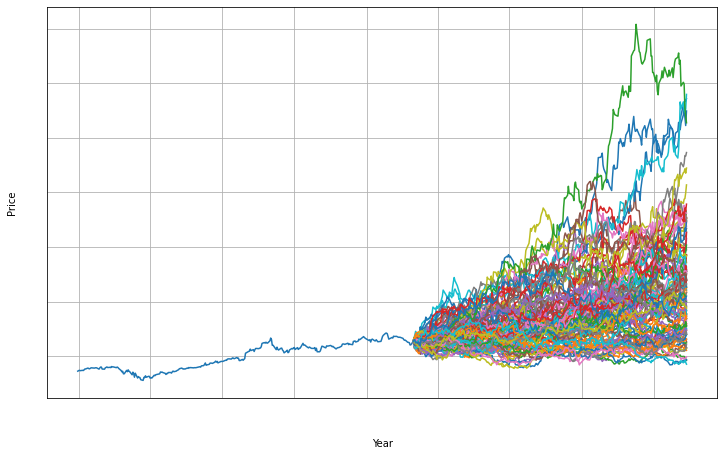

In [10]:
columns_ = np.arange(0, 100)
index_ = np.arange(0, len(df.index)-len(simulation.index))
empty_df = pd.DataFrame(columns=columns_, index=index_)
simulation = pd.concat([empty_df, simulation])
simulation.index = df.index
to_plot = pd.concat([df['Adj Close'], simulation], axis=1)

to_plot.plot(figsize=(12,8),grid=True,legend=False)
plt.tick_params(axis='both', colors='white')
plt.xlabel('Year')
plt.ylabel('Price')

Date depuis laquelle les marches aléatoires peuvent être générées : 2021-03-01


,Adj Close,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,72.245934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,73.894333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,73.175919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,73.759010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,73.412109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,171.660004,336.109138,271.180003,265.703668,204.497886,213.788731,62.091531,138.490637,319.652780,276.059775,...,487.469935,154.762379,351.703904,105.272868,247.119397,238.031973,208.202019,414.201883,184.394273,176.783663
2022-02-08,174.830002,316.058004,283.428693,268.971907,196.009355,217.063086,65.172860,139.100077,314.281279,271.126995,...,473.194915,152.396264,353.328843,99.022997,253.517041,244.358492,211.612077,407.984036,186.925198,187.225106
2022-02-09,176.279999,337.631688,278.883509,281.087601,189.460964,217.178453,69.190337,149.483351,316.595200,262.352123,...,458.238374,151.740808,362.065147,99.028207,246.217798,240.956401,215.691490,412.771561,193.136432,186.687646


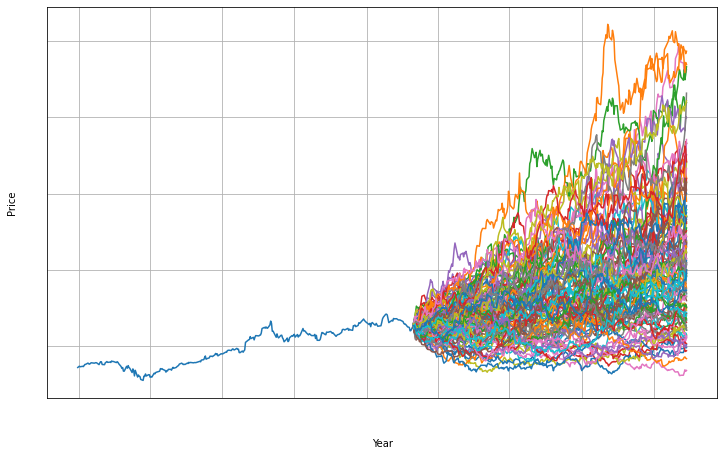

In [11]:
isValidDate = False
while(isValidDate == False):
    begin_date = input('Date depuis laquelle les marches aléatoires peuvent être générées : ')
    if begin_date in df.index :
        isValidDate = True
        break
    else:
        isValidDate = False
        print('NE selectionnez pas un weekend !')

end_date = datetime.today().strftime('%Y-%m-%d')
t = np.busday_count(begin_date, end_date)
paths = 100
df['daily_pct_change'] = df['Adj Close'].pct_change() 
initial_price = df['Adj Close'][begin_date]
mu = df['daily_pct_change'].iloc[:-t].mean()
sigma = df['daily_pct_change'].iloc[:-t].std()
simulation = {}
simulation['Actual'] = list(df['Adj Close'].loc[begin_date:].values)

for sim in range(paths):
    simulation["Simulation_"+str(sim)] = [df['Adj Close'].loc[begin_date]]
    for days in range(len(df['Adj Close'].loc[begin_date:])-1):
        next_day = simulation["Simulation_"+str(sim)][-1]*np.exp((mu-(sigma**2/2))+sigma*np.random.normal())
        simulation["Simulation_"+str(sim)].append(next_day)

simulation = pd.DataFrame(simulation).drop(columns='Actual')
for i in range(100):
    simulation = simulation.rename(columns={'Simulation_'+str(i): i})

columns_ = np.arange(0, 100)
index_ = np.arange(0, len(df.index)-len(simulation.index))
empty_df = pd.DataFrame(columns=columns_, index=index_)
simulation = pd.concat([empty_df, simulation])
simulation.index = df.index
to_plot = pd.concat([df['Adj Close'], simulation], axis=1)

to_plot.plot(figsize=(12,8),grid=True,legend=False)
plt.tick_params(axis='both', colors='white')
plt.xlabel('Year')
plt.ylabel('Price')
to_plot

Date depuis laquelle les marches aléatoires peuvent être générées : 2021-03-01


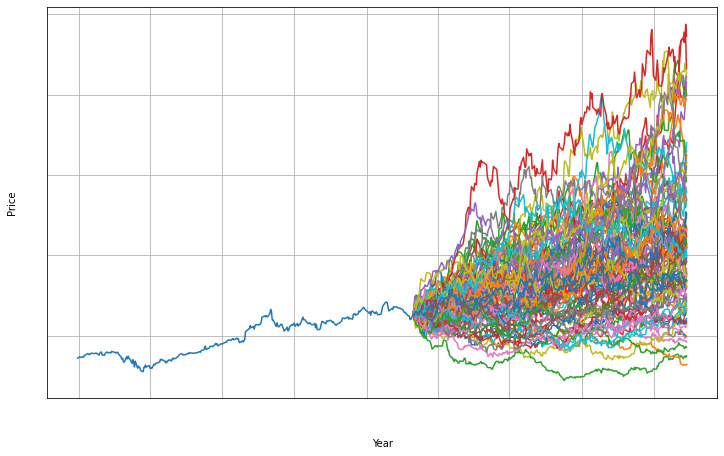

In [12]:
def random_walks_generator(paths):
    isValidDate = False
    while(isValidDate == False):
        begin_date = input('Date depuis laquelle les marches aléatoires peuvent être générées : ')
        if begin_date in df.index :
            isValidDate = True
            break
        else:
            isValidDate = False
            print('NE selectionnez pas un weekend !')
    
    end_date = datetime.today().strftime('%Y-%m-%d')
    condition = True
    t = np.busday_count(begin_date, end_date)
    df['daily_pct_change'] = df['Adj Close'].pct_change() 
    initial_price = df['Adj Close'][begin_date]
    mu = df['daily_pct_change'].iloc[:-t].mean()
    sigma = df['daily_pct_change'].iloc[:-t].std()
    simulation = {}
    simulation['Actual'] = list(df['Adj Close'].loc[begin_date:].values)

    for sim in range(paths):
        simulation["Simulation_"+str(sim)] = [df['Adj Close'].loc[begin_date]]
        for days in range(len(df['Adj Close'].loc[begin_date:])-1):
            next_day = simulation["Simulation_"+str(sim)][-1]*np.exp((mu-(sigma**2/2))+sigma*np.random.normal())
            simulation["Simulation_"+str(sim)].append(next_day)

    simulation = pd.DataFrame(simulation).drop(columns='Actual')
    for i in range(100):
        simulation = simulation.rename(columns={'Simulation_'+str(i): i})

    columns_ = np.arange(0, 100)
    index_ = np.arange(0, len(df.index)-len(simulation.index))
    empty_df = pd.DataFrame(columns=columns_, index=index_)
    simulation = pd.concat([empty_df, simulation])
    simulation.index = df.index
    to_plot = pd.concat([df['Adj Close'], simulation], axis=1)

    to_plot.plot(figsize=(12,8),grid=True,legend=False)
    plt.tick_params(axis='both', colors='white')
    plt.xlabel('Year')
    plt.ylabel('Price')
    to_plot
    
    return begin_date, end_date, simulation

begin_date, end_date, random_walks = random_walks_generator(100)

Calculating the fair price of the Apple share by averaging the values at the final time of the random walks and updating it to today.

In [13]:
def fair_price(random_walks, risk):
    random_walks_avg = np.average(random_walks.iloc[-1])
    fair_price = random_walks_avg*np.exp(-risk*(0)) # ici T-t = 0 car l'instant final des marches est aujourd'hui
    return fair_price

In [14]:
round(fair_price(random_walks, .01),2)

218.53

--------

## Option pricing with Monte Carlo

Taking a Call option on Apple stocks.

In [15]:
aapl = yf.Ticker('AAPL')
# shows options expirations dates
aapl.options

# gets option chain for specific expiration
opt = aapl.option_chain(aapl.options[-2])

# gets first option
appl_call_option = opt.calls.loc[[0]]
aapl_call_option_df = pd.DataFrame(appl_call_option)
aapl_call_option_df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL230915C00070000,2022-02-11 14:56:39+00:00,70.0,104.5,99.55,103.0,-3.550003,-3.285519,1,80,0.508306,True,REGULAR,USD


Generating the random walks of the underlying asset prices from today until the option expiration date (time steps = days between today and the maturity).

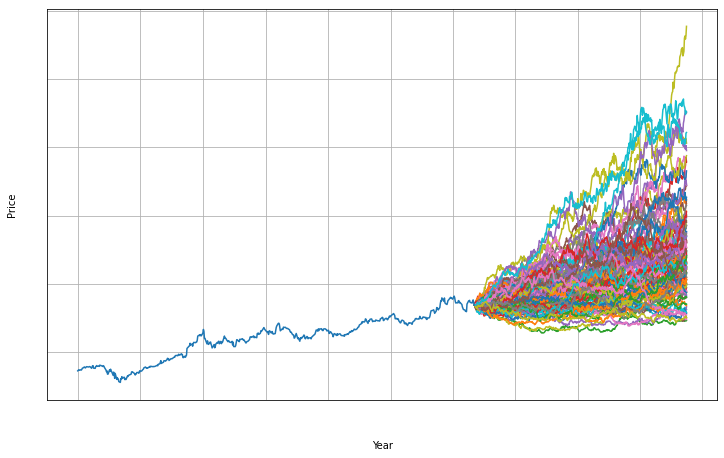

In [16]:
begin_date =  datetime.today().strftime('%Y-%m-%d')
end_date = aapl.options[-2]

def options_random_walks_generator(begin_date, end_date, paths):
    initial_price = df['Adj Close'][-1]
    t = np.busday_count(begin_date, end_date)
    df['daily_pct_change'] = df['Adj Close'].pct_change()
    mu = df['daily_pct_change'].iloc[-t:].mean()
    sigma = df['daily_pct_change'].iloc[-t:].std()
    
    simulation = {}
    simulation['Actual'] = list(df['Adj Close'].iloc[-t:].values)
    for sim in range(paths):
        simulation["Simulation_"+str(sim)] = [df['Adj Close'].iloc[-t]]
        for days in range(t-1):
            next_day = simulation["Simulation_"+str(sim)][-1]*np.exp((mu-(sigma**2/2))+sigma*np.random.normal())
            simulation["Simulation_"+str(sim)].append(next_day)

    days_to_maturity = []
    for i in range(t):
        days_to_maturity.append(date.today()+timedelta(days=i))
    df_days_to_maturity = pd.DataFrame(days_to_maturity)
    df_days_to_maturity.columns = ['Dates']
    df_days_to_maturity.set_index('Dates')
    
    sim_actual = pd.DataFrame(simulation['Actual'])
    sim_actual.index=df[-t:].index
    simulation_=pd.DataFrame(simulation)
    
    value_to_add = simulation_['Actual'].iloc[0] - df['Adj Close'].iloc[-1]
    value_to_add = abs(value_to_add)
    simulation_ += value_to_add
    
    value_to_add = simulation_['Actual'].iloc[0] - df['Adj Close'].iloc[-1]
    value_to_add = abs(value_to_add)
    simulation_ += value_to_add
    simulation_ = simulation_.drop(['Actual'], axis=1)
    simulation_['Date'] = days_to_maturity
    simulation_ = simulation_.set_index(['Date'])  
    
    simulation_.plot(figsize=(12,8),grid=True,legend=False)
    df['Adj Close'].plot(figsize=(12,8),grid=True,legend=False)
    plt.tick_params(axis='both', colors='white')
    plt.xlabel('Year')
    plt.ylabel('Price')
    return simulation_

options_random_walks = options_random_walks_generator(begin_date, end_date, 100)

In [17]:
options_random_walks

,Simulation_0,Simulation_1,Simulation_2,Simulation_3,Simulation_4,Simulation_5,Simulation_6,Simulation_7,Simulation_8,Simulation_9,...,Simulation_90,Simulation_91,Simulation_92,Simulation_93,Simulation_94,Simulation_95,Simulation_96,Simulation_97,Simulation_98,Simulation_99
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-12,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,...,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999,168.639999
2022-02-13,170.187716,169.738928,169.090544,169.355021,165.340241,170.633514,170.558758,167.982087,167.485829,168.642826,...,167.281846,168.879591,166.402086,170.929677,168.321330,164.998037,168.807641,169.102820,166.555706,168.919832
2022-02-14,172.922609,173.048369,168.940669,171.345289,164.487878,171.409706,170.111118,165.725396,168.431087,169.354536,...,168.272516,168.079075,167.861366,172.741729,167.595992,163.166298,170.484292,166.355645,165.989082,168.583105
2022-02-15,172.490773,173.272843,169.347916,171.835058,164.879107,175.274350,169.907215,166.776251,171.047508,170.220514,...,168.112960,167.638254,167.446284,171.500275,165.724748,161.923872,169.039306,167.492444,164.449379,168.994508
2022-02-16,170.934695,173.523844,168.930793,170.807297,165.647555,176.255533,171.738534,165.681500,168.725850,168.320176,...,169.690465,167.254332,167.620400,171.574057,165.943086,163.146327,168.629040,169.343823,165.591514,169.686332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-28,201.117793,206.490960,242.655797,366.649517,275.336533,338.953360,258.834389,281.950691,405.977115,260.179942,...,188.818017,200.847065,230.308370,293.830407,223.231651,244.311110,151.336403,216.506803,150.300522,459.527662
2023-03-29,203.364614,205.719650,241.659470,367.827507,278.173019,337.411161,260.378052,289.856949,412.575701,253.041612,...,189.710873,198.878688,234.060162,298.609427,224.473911,245.138359,148.799514,215.808894,150.838004,456.823374
2023-03-30,202.457644,201.453248,237.725741,373.497394,277.597150,338.759432,263.840076,281.118152,412.169945,258.251974,...,188.074502,201.737800,234.766914,299.383158,223.939318,249.662667,147.314820,217.917492,152.542993,448.107573


Computing the payoff of the chosen option (at maturity) for each of the random walks.

In [18]:
def call_payoff(sT, K):
    return max(sT-K, 0)

K = aapl_call_option_df['strike'][0]
call_payoff_ = []

for random_walk in range(100):
    sT = options_random_walks['Simulation_'+str(random_walk)][-1]
    call_payoff_.append(call_payoff(sT, K))
call_payoff_ = pd.DataFrame(call_payoff_)
call_payoff_

,0
0,135.658813
1,128.934606
2,178.325715
3,308.615414
4,203.654989
...,...
95,177.942609
96,77.787377
97,139.323909
98,79.765165


Computing average of the payoffs.

In [20]:
aapl_call_payoff_mean = call_payoff_.mean()
print('The average of the payoffs computed from random walks is :', aapl_call_payoff_mean[0])

The average of the payoffs computed from random walks is : 179.57742086659036


Bringing the average to today's value of money.

In [22]:
t = np.busday_count(begin_date, end_date)
aapl_call_option_price = aapl_call_payoff_mean[0] * np.exp(-0.01*t/252)
aapl_call_option_price

176.65132200504846

In [23]:
premium_ = aapl_call_option_df['lastPrice'][0]
net_profit = []

for random_walk in range(100):
    sT = options_random_walks['Simulation_'+str(random_walk)][-1]
    net_profit.append(call_payoff(sT, K) - premium_)
net_profit = pd.DataFrame(net_profit)
net_profit_average = net_profit.mean()
t = np.busday_count(begin_date, end_date)
net_profit_ = net_profit_average[0] * np.exp(-0.01*t/252)
print('The average of the net profit is : ', net_profit_)

The average of the net profit is :  73.85408246098727


In [24]:
class European_Call_Payoff:

    def __init__(self, strike):
        self.strike = strike

    def get_payoff(self, stock_price):
        if stock_price > self.strike:
            return stock_price - self.strike
        else:
            return 0


class GeometricBrownianMotion:

    def simulate_paths(self):
        while(self.T - self.dt > 0):
            dWt = np.random.normal(0, math.sqrt(self.dt))  # Brownian motion
            dYt = self.drift*self.dt + self.volatility*dWt  # Change in price
            self.current_price += dYt  # Add the change to the current price
            self.prices.append(self.current_price)  # Append new price to series
            self.T -= self.dt  # Accound for the step in time

    def __init__(self, initial_price, drift, volatility, dt, T):
        self.current_price = initial_price
        self.initial_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.dt = dt
        self.T = T
        self.prices = []
        self.simulate_paths()

# Model Parameters
sigma = df['Adj Close'].pct_change().std() * (252**0.5)
r = 0.01
S = df['Adj Close'][-1] # underlying_stock_current_price
strike = aapl_call_option_df['strike'][0]  
t = np.busday_count(begin_date, end_date)

paths = 100
initial_price = S
drift = .08
volatility = sigma
dt = 1/365
T = dt
price_paths = []



# Generate a set of sample paths
for i in range(0, paths):
    price_paths.append(GeometricBrownianMotion(initial_price, drift, volatility, dt, T).prices)

call_payoffs = []
ec = European_Call_Payoff(100)
risk_free_rate = .01
for price_path in price_paths:
    call_payoffs.append(ec.get_payoff(price_path[-1])/(1 + risk_free_rate))  # We get the last stock price in the series generated by GBM to determin the payoff and discount it by one year

# Plot the set of generated sample paths
for price_path in price_paths:
    plt.plot(price_path)
plt.show()

print(np.average(call_payoffs)*100)  # Options are in blocks of 100

IndexError: list index out of range

-----

## Option pricing with Black-Scholes

Creating functions for both Call and Put options.

In [25]:
N = norm.cdf

def BS_call(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return S*np.exp(-q*T) * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_put(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*np.exp(-q*T)*N(-d1)

In [26]:
sigma = df['Adj Close'].pct_change().std() * (252**0.5)
r = 0.01
S = df['Adj Close'][-1] # underlying_stock_current_price
strike = aapl_call_option_df['strike'][0]  
t = np.busday_count(begin_date, end_date)

BS_call(S, strike, t, r, 0, sigma)

168.63822957969714

In [27]:
begin_date = datetime.today().strftime('%Y-%m-%d')
end_date = aapl.options[-2]
t = np.busday_count(begin_date, end_date)
'''
    S = current stock price, K = strike price, sigma = volatility of underlying asset
    r = risk-free interest rate, T = time to maturity, N = normal distribution
'''
def call_price(S, sigma, K, t, r):
    b = math.exp(-r*t)
    x1 = math.log(S/(b*K)) + .5*(S*sigma)*t
    x1 = x1/(sigma*(t**.5))
    z1 = norm.cdf(x1)
    z1 = z1*S
    x2 = math.log(S/(b*K)) - .5*(sigma**2)*t
    x2 = x2/(sigma*(t**.5))
    z2 = norm.cdf(x2)
    z2 = b*K*z2
    return z1 - z2

sigma = df['Adj Close'].pct_change().std() * (252**0.5)
r = 0.01
S = df['Adj Close'][-1] # underlying_stock_current_price
K = aapl_call_option_df['strike'][0]  
t = np.busday_count(begin_date, end_date)

bs_call_option_price = call_price(S, sigma, K, t, r)

In [28]:
print("Monte Carlo pricing : ", aapl_call_option_price)
print("Black-Scholes pricing : ", bs_call_option_price)
print("Market pricing : ", aapl_call_option_df['lastPrice'][0])

Monte Carlo pricing :  176.65132200504846
Black-Scholes pricing :  168.63897588171685
Market pricing :  104.5


----

## Volatility surface

Taking a bunch of European Call options on Apple stocks (with different expiration dates and strike prices).

In [29]:
dates_list = list(aapl.options)
del(dates_list[0])
dates_list

['2022-02-25',
 '2022-03-04',
 '2022-03-11',
 '2022-03-18',
 '2022-03-25',
 '2022-04-14',
 '2022-05-20',
 '2022-06-17',
 '2022-07-15',
 '2022-08-19',
 '2022-09-16',
 '2022-10-21',
 '2022-11-18',
 '2023-01-20',
 '2023-03-17',
 '2023-06-16',
 '2023-09-15',
 '2024-01-19']

In [30]:
aapl = yf.Ticker('AAPL')
# show options expirations
column_names = ['contractSymbol', 'lastTradeDate', 'strike',
                                               'lastPrice', 'bid', 'ask', 'change', 'percentChange',
                                               'volume', 'openInterest', 'impliedVolatility',
                                               'inTheMoney', 'contractSize', 'currency']
opt_list = pd.DataFrame(columns=column_names)
i = 0
for date in dates_list:
    # get option chain for specific expiration
    opt = aapl.option_chain(date)
    # random item from list
    appl_call_option = opt.calls.loc[[i]]
    appl_call_option = pd.DataFrame(appl_call_option)
    opt_list = pd.concat([opt_list, appl_call_option], ignore_index=True)
    i += 1
opt_list

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220225C00105000,2022-02-02 16:51:51+00:00,105.0,69.00,62.05,65.65,0.000000,0.000000,10,0,1.166020,True,REGULAR,USD
1,AAPL220304C00110000,2022-02-09 14:31:45+00:00,110.0,66.00,57.10,60.80,0.000000,0.000000,4,0,0.923829,True,REGULAR,USD
2,AAPL220311C00120000,2022-02-09 18:18:08+00:00,120.0,55.80,47.15,51.00,0.000000,0.000000,10.0,12,0.698733,True,REGULAR,USD
3,AAPL220318C00085000,2022-02-03 19:41:21+00:00,85.0,89.50,82.20,84.20,0.000000,0.000000,1770,0,1.199223,True,REGULAR,USD
4,AAPL220325C00155000,2022-02-11 20:18:14+00:00,155.0,16.55,15.50,18.30,-5.480001,-24.875175,2,19,0.459173,True,REGULAR,USD
5,AAPL220414C00075000,2022-01-28 17:06:07+00:00,75.0,93.93,93.15,94.60,0.000000,0.000000,24,0,0.914063,True,REGULAR,USD
6,AAPL220520C00105000,2022-02-09 16:16:10+00:00,105.0,71.05,63.55,65.00,0.000000,0.000000,10,265,0.531255,True,REGULAR,USD
7,AAPL220617C00037500,2022-02-04 17:26:30+00:00,37.5,134.45,130.60,132.20,0.000000,0.000000,103,0,1.166020,True,REGULAR,USD
8,AAPL220715C00105000,2022-02-11 20:53:11+00:00,105.0,65.16,64.30,65.75,-4.619995,-6.620801,1,64,0.500249,True,REGULAR,USD
9,AAPL220819C00130000,2022-02-07 17:18:10+00:00,130.0,45.64,40.75,44.60,0.000000,0.000000,43.0,76,0.458929,True,REGULAR,USD


In [31]:
""" Preparing parameters """
sigma = df['daily_pct_change'].std() * (252**0.5)
S = df['Adj Close'][-1]   
r = .01

K_values = []
for i in range(len(opt_list)):
    K_values.append(opt_list['strike'][i])

dates = []
for date in dates_list:
    dates.append(date) # get option chain for specific expiration
    
t_values = []
for i in range(len(opt_list)):
    begin_date = datetime.today().strftime('%Y-%m-%d')
    end_date = dates[i]
    t_values.append(np.busday_count(begin_date, end_date)) # time to maturity

def call_price(S, sigma, K, t, r):
    b = math.exp(-r*t)
    x1 = math.log(S/(b*K)) + .5*(S*sigma)*t
    x1 = x1/(sigma*(t**.5))
    z1 = norm.cdf(x1)
    z1 = z1*S
    x2 = math.log(S/(b*K)) - .5*(sigma**2)*t
    x2 = x2/(sigma*(t**.5))
    z2 = norm.cdf(x2)
    z2 = b*K*z2
    return z1 - z2

C_values = []
for i in range(len(opt_list)):
    K = K_values[i]
    t = t_values[i]
    C_values.append(call_price(S, sigma, K, t, r))

In [32]:
def impliedvol(S, K, t, r, C, sigma):
    def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - (sigma * np.sqrt(t))
        BS_price_call = S * si.norm.cdf(d1,0,1) - K * np.exp(-r * t) * si.norm.cdf(d2,0,1)
        fx = BS_price_call - C
        return fx

    return optimize.brentq(bs_price, 0.0001, 100, maxiter=1000)

implied_volatilities = []
for x in range(len(opt_list)):
    K = K_values[x]
    t = t_values[x]
    C = C_values[x]
    iv = impliedvol(S, K, t, r, C, sigma)
    implied_volatilities.append(iv)
iv1 = implied_volatilities
iv1

[0.5969331806311282,
 0.5570370613570824,
 0.5332717277647964,
 0.4942265833912069,
 0.5054016192315098,
 0.45453776514055677,
 0.4352316813423636,
 0.4166889915222299,
 0.41586494970690774,
 0.4097340034551418,
 0.40279512013516705,
 0.4013948495277143,
 0.39877204464898125,
 0.39364341728655106,
 0.39110831613630204,
 0.38774237989914406,
 0.3854049604457877,
 0.3830010563551166]

C:\Users\filip\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=6,7 m=18 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


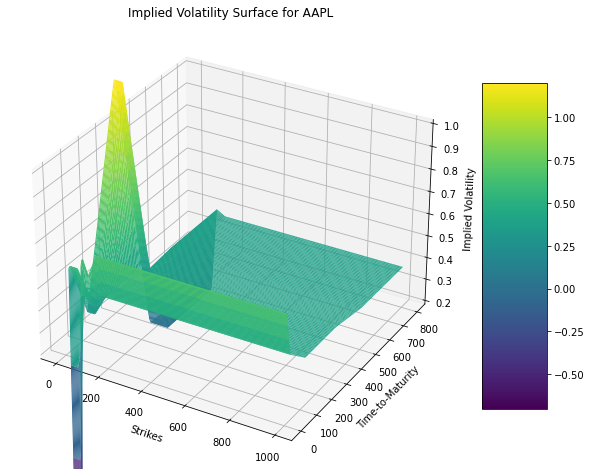

In [33]:
ttm = t_values
strikes = K_values
imp_vol = iv1
f = interp2d(strikes,ttm,imp_vol, kind='linear')
 
plot_strikes = np.linspace(0, 1000,200)
plot_ttm = np.linspace(0, 800, 100)
fig = plt.figure(figsize=(10,12))
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_ttm)
Z = np.array([f(x,y) for xr, yr in zip(X, Y) for x, y in zip(xr,yr) ]).reshape(len(X), len(X[0]))
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis',linewidth=0.1)
ax.set_zlim(0.2, 1)
ax.set_xlabel('Strikes')
ax.set_ylabel('Time-to-Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface for AAPL');
fig.colorbar(surf, shrink=0.5, aspect=5)